In [1]:
!pip install pythainlp
!pip install deepcut

In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Utility
from collections import Counter
import numpy as np

# nltk
from pythainlp.corpus import thai_stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import time

import deepcut

In [3]:
# DATASET
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024


# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

In [4]:
def tokenize_thai(text):
    token = deepcut.tokenize(text)
    token_with_whitespace = ' '.join(token)
    return token_with_whitespace


In [5]:
df_neg = pd.read_fwf('/content/drive/MyDrive/work/sentiment/sentiment_th/sentiment_one_dependent_variable/neg.txt', header=None)
df_neu = pd.read_fwf('/content/drive/MyDrive/work/sentiment/sentiment_th/sentiment_one_dependent_variable/neu.txt', header=None)
df_pos = pd.read_fwf('/content/drive/MyDrive/work/sentiment/sentiment_th/sentiment_one_dependent_variable/pos.txt', header=None)

df_neg['sentiment'] = ['NEGATIVE' for i in range(len(df_neg))]
df_neu['sentiment'] = ['NEUTRAL' for i in range(len(df_neu))]
df_pos['sentiment'] = ['POSITIVE' for i in range(len(df_pos))]

df_not_clean = pd.concat([df_neg,df_neu,df_pos]).reset_index()[[0,'sentiment']]
df_not_clean

,0,sentiment
0,☹️,NEGATIVE
1,😔,NEGATIVE
2,😞,NEGATIVE
3,😥,NEGATIVE
4,รำ,NEGATIVE
...,...,...
26157,พูดถึ,POSITIVE
26158,เรื่อ,POSITIVE
26159,🌞แสงแ,POSITIVE
26160,เราชื,POSITIVE


In [6]:
neu_stm = df_not_clean['sentiment'].value_counts()["NEUTRAL"]
neg_stm = df_not_clean['sentiment'].value_counts()["NEGATIVE"]
pos_stm = df_not_clean['sentiment'].value_counts()["POSITIVE"]
neu_stm,neg_stm,pos_stm

(14561, 6823, 4778)

In [7]:
df = df_not_clean[[0,'sentiment']]
df.columns = ['text', 'target']
df = df[df['target'] != 'NEUTRAL']
df

,text,target
0,☹️,NEGATIVE
1,😔,NEGATIVE
2,😞,NEGATIVE
3,😥,NEGATIVE
4,รำ,NEGATIVE
...,...,...
26157,พูดถึ,POSITIVE
26158,เรื่อ,POSITIVE
26159,🌞แสงแ,POSITIVE
26160,เราชื,POSITIVE


Text(0.5, 1.0, 'Dataset labels distribuition')

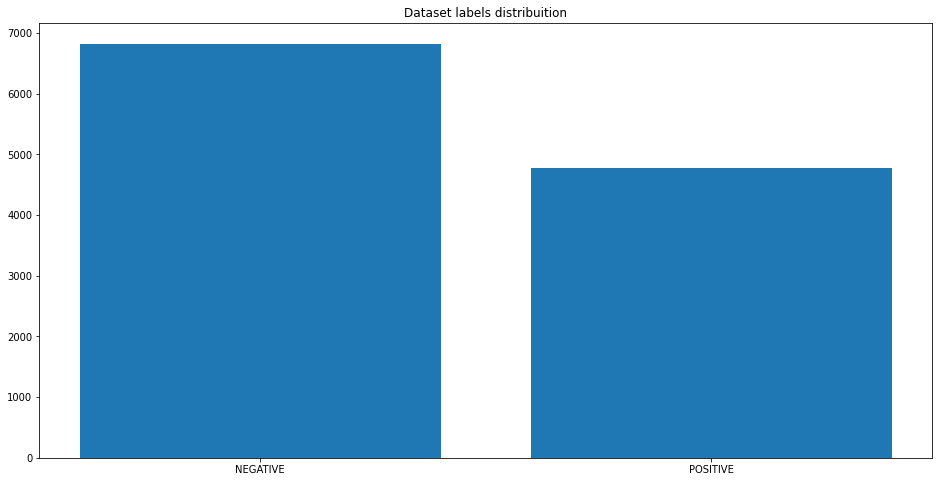

In [8]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [9]:
stop_words = thai_stopwords()
print(stop_words)
#ไม่ได้ทำstemmerเพราะยังไม่เจอในไทย
stemmer = SnowballStemmer("english")
print(stemmer)

frozenset({'รึว่า', 'ครั้งก่อน', 'อันละ', 'ไม่ใช่', 'นาน', 'ด้วยเหมือนกัน', 'มิ', 'เมื่อเย็น', 'ครั้งนั้น', 'สบาย', 'ประสบ', 'เหตุ', 'ต่างก็', 'บ่อยๆ', 'แต่', 'ค่อนข้าง', 'พวกมึง', 'ใคร่จะ', 'ใช่ไหม', 'เมื่อก่อน', 'ด้วย', 'มั้ย', 'นอก', 'นี้แหล่', 'ตรง', 'เพียงเพราะ', 'เสียแล้ว', 'กันนะ', 'ค่อนข้างจะ', 'หมดกัน', 'เป็นที่สุด', 'ก็แค่', 'ครั้งครา', 'เหล่านั้น', 'ตนฯ', 'หรือไร', 'อย่างละ', 'กู', 'แก', 'แรก', 'อันเนื่องมาจาก', 'พอที', 'หนอย', 'ส่วนมาก', 'เคย', 'อยู่', 'มิได้', 'ก็จะ', 'เหตุผล', 'ครัน', 'ถึงเมื่อไร', 'นำมา', 'กลุ่ม', 'เมื่อคราว', 'เชื่อ', 'พวกเธอ', 'เพื่อที่', 'คราวใด', 'ก่อนหน้า', 'สั้นๆ', 'ยก', 'อะไร', 'เป็นแต่', 'เผื่อ', 'หน่อย', 'ตลอดวัน', 'นอกจากนี้', 'บัดดล', 'จรดกับ', 'นับจากนี้', 'ยาก', 'เป็นเพราะ', 'เอา', 'นานๆ', 'ที่ว่า', 'นำ', 'อันใด', 'ได้มา', 'ที่ได้', 'เท่าไร', 'น้อย', 'เห็นควร', 'บ่อยกว่า', 'เหล่านี้', 'หลังจาก', 'ส่ง', 'เมื่อ', 'หากว่า', 'ไหน', 'เป็นที', 'ยังไง', 'หลัง', 'ทุกคน', 'สมัยโน้น', 'กว้าง', 'นี้', 'เขา', 'ดังเคย', 'ครั้ง', 'คือ', 'ง่าย', 'กลุ่มก้อน

In [10]:
# ทำregular expression เอาคำไหนมา
# def preprocess(text, stem=False):
#     # Remove link,user and special characters
#     text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
#     tokens = []
#     for token in text.split():
#         if token not in stop_words:
#             if stem:
#                 tokens.append(stemmer.stem(token))
#             else:
#                 tokens.append(token)
#     return " ".join(tokens)

In [11]:
# %%time
# df.text = df.text.apply(lambda x: preprocess(x))
# df.text

In [12]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))
print(df_train)
print('=============')
print(df_test)

TRAIN size: 9280
TEST size: 2321
           text    target
24445     หนาวเ  POSITIVE
22845     ไปจัด  POSITIVE
3143   ดูไม่ออก  NEGATIVE
4029   อาทิตย์ห  NEGATIVE
2390   หนังเลิก  NEGATIVE
...         ...       ...
25845     คนที่  POSITIVE
5191   มีอาการค  NEGATIVE
5390   พระเขาไม  NEGATIVE
860    การเมือง  NEGATIVE
21831     ปะกิน  POSITIVE

[9280 rows x 2 columns]
           text    target
5384   ทีนี้กูไ  NEGATIVE
24059     เทอออ  POSITIVE
2952   ชุดนี้แห  NEGATIVE
6654   สัปดาก่อ  NEGATIVE
25547     Refre  POSITIVE
...         ...       ...
4394    ต่อไปกู  NEGATIVE
21433      ง้ำๆ  POSITIVE
5304   ซ้ายตัวเ  NEGATIVE
4606   เยสเข้ น  NEGATIVE
24615     อร่อย  POSITIVE

[2321 rows x 2 columns]


In [13]:
%%time
documents = [_text.split() for _text in df_train.text] 
documents

CPU times: user 5.82 ms, sys: 1.98 ms, total: 7.8 ms
Wall time: 7.81 ms


In [14]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [15]:
w2v_model.build_vocab(documents)

In [16]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 58


In [17]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 406 ms, sys: 54.6 ms, total: 461 ms
Wall time: 573 ms


(10563, 325600)

In [18]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 7227
CPU times: user 89.1 ms, sys: 1.05 ms, total: 90.1 ms
Wall time: 104 ms


In [19]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 130 ms, sys: 3.79 ms, total: 134 ms
Wall time: 137 ms


In [20]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [21]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (9280, 1)
y_test (2321, 1)


In [22]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (9280, 300)
y_train (9280, 1)

x_test (2321, 300)
y_test (2321, 1)


In [23]:
y_train[:10]

array([[1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1]])

In [24]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(7227, 300)


In [25]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)
embedding_layer


In [26]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          2168100   
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 2,328,601
Trainable params: 160,501
Non-trainable params: 2,168,100
_________________________________________________________________


In [27]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [28]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [29]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    # epochs=2,

                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
9/9 [==============================] - 111s 12s/step - loss: 0.6899 - accuracy: 0.5904 - val_loss: 0.6821 - val_accuracy: 0.5851
Epoch 2/8
9/9 [==============================] - 105s 12s/step - loss: 0.6813 - accuracy: 0.5840 - val_loss: 0.6795 - val_accuracy: 0.5851
Epoch 3/8
9/9 [==============================] - 107s 12s/step - loss: 0.6790 - accuracy: 0.5871 - val_loss: 0.6786 - val_accuracy: 0.5851
Epoch 4/8
9/9 [==============================] - 105s 12s/step - loss: 0.6783 - accuracy: 0.5864 - val_loss: 0.6789 - val_accuracy: 0.5851
Epoch 5/8
9/9 [==============================] - 105s 12s/step - loss: 0.6785 - accuracy: 0.5860 - val_loss: 0.6784 - val_accuracy: 0.5851
Epoch 6/8
9/9 [==============================] - 105s 12s/step - loss: 0.6806 - accuracy: 0.5786 - val_loss: 0.6784 - val_accuracy: 0.5851
Epoch 7/8
9/9 [==============================] - 105s 12s/step - loss: 0.6775 - accuracy: 0.5881 - val_loss: 0.6784 - val_accuracy: 0.5851
Epoch 8/8
9/9 [============

In [30]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

3/3 [==============================] - 6s 2s/step - loss: 0.6747 - accuracy: 0.5976

ACCURACY: 0.5975872278213501
LOSS: 0.6747081279754639
CPU times: user 11.4 s, sys: 593 ms, total: 12 s
Wall time: 6.28 s


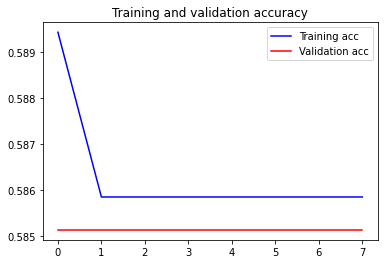

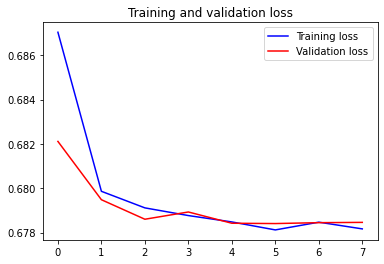

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [32]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [33]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [34]:
predict("ไม่ดี")

{'elapsed_time': 0.3409099578857422,
 'label': 'NEUTRAL',
 'score': 0.42400962114334106}

In [35]:
predict("เยี่ยมยอด")

{'elapsed_time': 0.08643031120300293,
 'label': 'NEUTRAL',
 'score': 0.42400962114334106}

In [36]:
predict("ดีมาก")

{'elapsed_time': 0.08745098114013672,
 'label': 'NEUTRAL',
 'score': 0.42400962114334106}

In [37]:
predict("เขาเป็นคนดี")

{'elapsed_time': 0.09886717796325684,
 'label': 'NEUTRAL',
 'score': 0.42400962114334106}